In [2]:
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Idea
Here we test the possiblity of interleaving measurments and algorithm
### Model
The main goal of the game is to minimize the sum of coin tosses $y_i$ in $N =100$ shots:
$$ 
    Q_{100} = |\sum_i^{100} y_i|, \text{where}\,\, y_i = \pm 1
$$
We assume each toss follows the probability distribution:
$$
 p(y_i = 1| \lambda, B) = \frac{1}{2} + \frac{1}{2}\cos(B \lambda),
$$
where the $\lambda$ can be seen as the 'strengh of the throw'. The parameter $B$ is stochastic, and follows diffiusion equation:
$$
\dot B(t) = \frac{1}{\tau_c}B(t) + \sigma w(t)
$$
where $w(t)$ is the derrivative of Wiener process. 


##### Actions:
Clearly the aim is to adjust $\lambda$ to our knowladge of $B$. We define two actions:
- (Y) Throw: $T(B_n,\lambda_n)$: throw a dice and count outcome $y_n$.
- (X) Estimate: $E(B_n,\tau_n)$: throw a dice but do not count the outcome $x_n$.

The idea behind the (E) is to allow to use a different throw strenghts $\tau \neq \lambda \approx (\pi/2 = 2k\pi)/B$

##### Estimation
Since for the action (X) we also have the probability model: $p(x_i = 1| \tau, B) = \frac{1}{2} + \frac{1}{2}\cos(B \tau)$, we can use both both actions to 
$$
p(B|x_i,\mathbf{x_{i-1}},\mathbf{y_{i-1}}) = \frac{p(x_i|B) p(B|\mathbf{x_{i-1}},\mathbf{y_{i-1}})}{p(B, x_i,\mathbf{x_{i-1}},\mathbf{y_{i-1}})}
$$
and similairly with $p(B|y_i,\mathbf{x_{i-1}},\mathbf{y_{i-1}})$

## Open AI gym


In [663]:
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np
# Load the TensorBoard notebook extension
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [901]:
import matplotlib.pyplot as plt




In [943]:
dt = 1
sig = 50
std0 = 10
avgB = 50
fmax = 1/1
fmin = 1/450

def get_initial_p(b0, sig, grid):
    p = np.exp(-(b0-grid)**2/sig/sig/2) 
    if np.sum(p)==0:
        p = np.zeros(len(grid))
        p[np.argmin(np.abs(b0-grid))] = 1
    return p/np.sum(p)


def update_p(d, phi, p0):
    q = 2*d-1
    p = p0*(1+q*np.cos(phi))/2.
    if np.sum(p)==0:
        return p0
    return p/np.sum(p)


def get_std(probs, grid):
    if 0 > np.sum(probs*grid**2)-np.sum(probs*grid)**2:
        return 0.5
    else:
        return np.sqrt(np.sum(probs*grid**2)-np.sum(probs*grid)**2)


def estimate(dom, grid, pdf_weights, om0=0, t = None):
    omega = dom+om0
   
    if t == None:
        std = get_std(pdf_weights, grid)
        
        if std <1e-2:
            std = 1e-2
        t = 1/4/std
    
    
    x = np.random.binomial(1, 1/2+1/2*np.cos(2*np.pi*omega*t))
    pdf_weights = update_p(x, 2*np.pi*(grid+om0)*t, pdf_weights)  #TODO

    return pdf_weights
            

def get_estimate(probs, grid):
    ind = np.argmax(probs)
    return grid[ind]

def get_initial_p(b0, sig, grid):
    if sig==0:
        sig = 0.1
        p = np.exp(-(b0-grid)**2/sig/sig/2)
    else:
        p = np.exp(-(b0-grid)**2/sig/sig/2)
    #print(p)
    return p/np.sum(p)

def next_B(b0, dt, sig,tc):
    return b0*np.exp(-dt/tc) + sig*np.sqrt(1-np.exp(-2*dt/tc))*np.random.normal()


def difuse_pdf(pdf, dt, sig, tc, grid):
    std = np.sqrt(sig**2*(1-np.exp(-2*dt/tc)))
    pdf_t = np.tile(pdf, (len(grid),1))
    grid_t = np.tile(grid, (len(pdf),1))
    grid_t2 = grid_t.T
    pdf = np.sum(pdf_t*np.exp(-(grid_t2-grid_t*np.exp(-dt/tc))**2/(2*std**2)), axis=1)
    return pdf/np.sum(pdf)
    

class EstimationEnv(Env):
    def __init__(self, tc):
        # Actions we can take, down, stay, up
        self.action_space = Discrete(3)
        self.om0 = avgB
        self.std0 = std0
        self.tc = tc
        self.observation_space = Box(low = -200, high = 200, shape = (2,),dtype=np.float32) #Implement observation space!
        # Frequency array
        self.freq_grid = np.linspace(-100,200,301)
        #self.weigths = get_initial_p(0, 50, self.freq_grid)
        # Set start temp
        self.dom = np.random.normal(0, sig)
        self.weigths = get_initial_p(self.dom, std0, self.freq_grid)
        #plt.plot(self.freq_grid,self.weigths)
        # Set shower length
        self.estimation_length = 100
        self.state = [get_estimate(self.weigths,self.freq_grid)+self.om0, get_std(self.weigths, self.freq_grid)]
        
    def step(self, action):
        # Need counter

        # Apply action
        # 0 - not estimate
        # 1 - estimate 
        reward = 0
        b = None

        mu = get_estimate(self.weigths, self.freq_grid) + self.om0
        std = get_std(self.weigths, self.freq_grid)
        #plt.figure()
        #plt.plot(self.freq_grid,self.weigths)
        #print(mu)
        #print(self.om0)
        #print( get_estimate(self.weigths, self.freq_grid) )
    
        if action == 0:
            if mu==0:
                b = 1
            else:
                t = 1/mu/2 # change np.pi in numerator to have different angle    
                b = np.random.binomial(1, 1/2+1/2*np.cos(2*np.pi*(self.om0+self.dom)*t))
            #self.weigths = update_p(b, 2*np.pi*self.freq_grid*t, self.weigths)
        elif action == 1:
        
            self.weigths = estimate(self.dom, self.freq_grid, self.weigths, self.om0)
        
        else:
            if mu != 0:
                t = 1/mu/2 # change np.pi in numerator to have different angle    
                self.weigths = estimate(self.dom, self.freq_grid, self.weigths, self.om0, t)
        
        # b = 0
        if b==0: 
            reward = 1
        elif b==1: 
            reward = -1
        else:
            reward = 0.0
        
        self.estimation_length -= 1
        # Check if estimation is done
        if self.estimation_length <= 0: 
            done = True
        else:
            done = False
        
        info = {"om":self.dom  }
        #plt.figure()
        #plt.plot(self.weigths)
        # Apply diffusion noise

        self.dom = next_B(self.dom, dt = dt, sig = sig, tc = self.tc)
        #self.weigths += difuse_pdf(self.omega,dt = dt, sig = sig, tc = tc, grid = self.freq_grid)
        self.state = get_std(self.weigths, self.freq_grid)
        self.weigths = difuse_pdf(self.weigths, dt = 1, sig = sig, tc = self.tc, grid = self.freq_grid)
        
        # Set placeholder for info
        truncated = False
        # Return step information
        #plt.plot(self.freq_grid,self.weigths)
        return  np.array([mu,std]).astype(np.float32), reward, done, truncated, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self,seed=None, options=None):
        # Reset field
        self.om0 = avgB
       
        # Set start temp
        # Reset estimation time
        self.dom = np.random.normal(0, sig)
        self.weigths = get_initial_p(self.dom, std0, self.freq_grid)
        self.estimation_length = 100
        mu = get_estimate(self.weigths, self.freq_grid) + self.om0
        std = get_std(self.weigths, self.freq_grid)
        info = {"om":self.dom}
        return np.array([mu,std]).astype(np.float32), info
    

In [944]:
tcs = [20,40,60,80,100]
env = EstimationEnv(tc = tcs[0])


In [905]:
episodes = 1
reward_0 = []
errors = []
stds = []
doms = []
mus = []
for episode in range(1, episodes+1):
    stds.append([])
    errors.append([])
    doms.append([])
    mus.append([])
    state = env.reset()
    done = False
    score = 0 
    k = 0
    while not done:
        #env.render()
        #action = 0
        #action = env.action_space.sample()
        action = np.random.choice([1,2], p=[0.5,0.5])
        n_state, reward, done, _, info = env.step(action)
        score+=reward
        k = k+1
        mu, std = n_state
        stds[-1].append(std)
        errors[-1].append(np.abs(info["om"] - mu))
        mus[-1].append(mu)
        doms[-1].append(info["om"])
    reward_0.append(score)
    
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:0.0


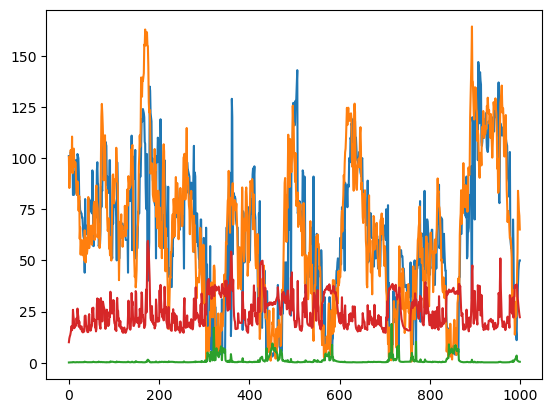

In [906]:
plt.plot(np.abs(np.array(mus[0])))
plt.plot(np.abs(np.array(doms[0])+avgB))
plt.plot(np.array(stds[0])/np.abs(np.array(mus[0])))
plt.plot(np.array(stds[0]))

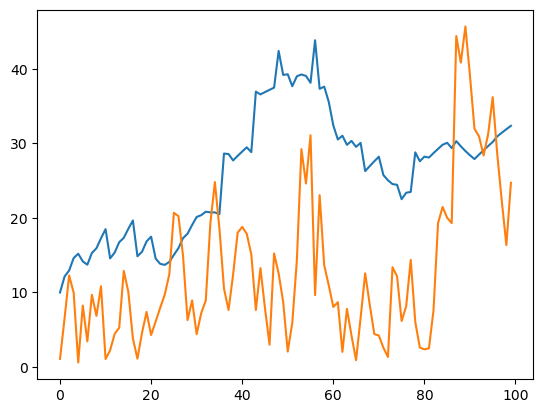

In [536]:
#plt.plot(np.array(stds).T)
plt.plot(np.average(stds,axis=0).T)
plt.plot(np.average(errors,axis=0).T)

In [945]:
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
logdir = "./ppo_bayes_tensorboard/"



for tc in tcs:
    env = EstimationEnv(tc = tc)
    if not os.path.exists("./ppo_bayes_tensorboard/"):
        os.makedirs("./ppo_bayes_tensorboard/")

    model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard/")
    model.learn(total_timesteps=100000, reset_num_timesteps=False, tb_log_name="PPO")
    model.save("ppo_N100"+str(tc))

    


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_bayes_tensorboard/PPO_0


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | 8.65     |
| time/              |          |
|    fps             | 850      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 9.53        |
| time/                   |             |
|    fps                  | 673         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007669545 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.0615      |
|    learning_rate        | 0.

In [23]:
%tensorboard --logdir ppo_bayes_tensorboard --port 6009

Reusing TensorBoard on port 6009 (pid 62198), started 2 days, 23:21:14 ago. (Use '!kill 62198' to kill it.)

In [968]:
scores = []
for tcn,tc in enumerate(tcs):
    model.load("ppo_N100"+str(tc))
    env = EstimationEnv(tc = tc)
    episodes = 100
    def play_agent(episodes, model):
        s_total = np.zeros(episodes)
        for episode in range(1, episodes+1):
            done = False
            k = 0
            n_state = env.reset()[0]
            while not done:
                action,_ = model.predict(n_state)
                n_state, reward, done, _, info = env.step(action)
                mu, std = n_state
                s_total[episode-1] += reward
                k = k+1
        return s_total

    scores.append(play_agent(episodes, model))

In [967]:
scores

[array([32.,  7.,  4., 29., -1., 17., 12., 10.,  0., 30.]),
 array([23., 36., 43., 45., 14., -4., 14.,  6., 15., 13.]),
 array([37., 30.,  3.,  3., 54., 29., 30., 10., -4., 65.]),
 array([ 2., 57., 14., -3.,  3., 42., 44.,  8., 49., 69.]),
 array([36., 33., 61., 53., 79., 31.,  2., 24., 46., 13.])]

In [973]:
plt.violinplot(np.array(scores).T, show_mean=True)
plt.xticks(np.arange(len(tcs))+1, tcs)

TypeError: violinplot() got an unexpected keyword argument 'show_mean'

In [ ]:
cmap = colors.ListedColormap(['b','r','w',"k"])
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

[30.]


In [897]:


for tc in tcs:
    model = model.load("ppo_bayes_no_bayes"+str(tc))
dones = False
samples = 6
runs = 200
actions = np.zeros((samples, runs))
rewards = np.zeros((samples, runs))
oms = np.zeros((samples, runs)) 
est_prob = np.zeros((samples))
check_prob = np.zeros((samples))
tot_reward = np.zeros((samples))
mus = np.zeros((samples, runs))
std = np.zeros((samples, runs))

for i in range(samples):
    k = 0
    dones = False
    obs = env.reset()[0]
    while not dones:
        action, _states = model.predict(obs)
        obs, reward, dones, truncate, info = env.step(action)
        rewards[i,k] = reward
        actions[i,k] = action*2
        if actions[i,k] == 0:
            actions[i,k] = reward 
        oms[i,k] = info["om"]
        mus[i,k] = obs[0]
        std[i,k] = obs[1]
        k = k+1
    actions[actions==-1] = 0
    
    est_prob[i] = np.sum(actions[i,:]==2)/len(actions[i,:])
    check_prob[i] = np.sum(actions[i,:]==4)/len(actions[i,:])
    tot_reward[i] = np.sum(rewards[i,:])


In [755]:
actions[actions==-1] = 0
#actions[actions==4] = 5

In [756]:
set(actions.flatten())

{0.0, 1.0, 2.0, 4.0}

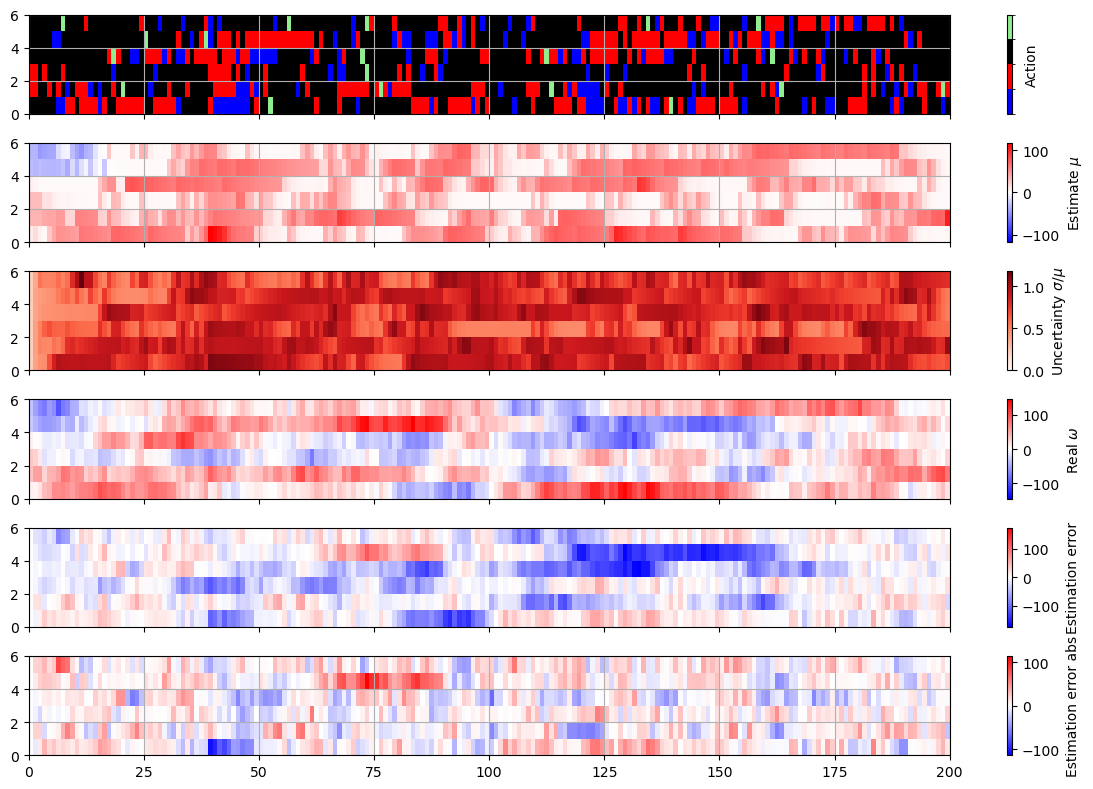

In [898]:
# Plot 3 panel subplot with actions, rewards and observations
fig, axs = plt.subplots(6, 1, figsize=(12, 8), sharex=True)

from matplotlib import colors
#axs[0].pcolormesh(actions, cmap='binary')
#axs[0].set_title('Actions')
# use the cmap which has blue for negative and red for positive values

#plot actions, color code them by action array with the code -1: "b", 1 "r", 2: "k", 4: "w" 
cmap = colors.ListedColormap(['b','r','k',"lightgreen"])
bounds = [-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

colors = ["b","r","k","w"]
d = axs[0].pcolormesh(actions, cmap=cmap, norm=norm)
axs[0].grid(True)
cb = plt.colorbar(d, ax = axs[0], orientation="vertical")
cb.set_label('Action')
cb.set_ticks([])
plt.tight_layout()
axs[0].grid(True)

#mu
dmu = mus
dmu_plot = axs[1].pcolormesh(dmu, cmap="bwr", vmin=-np.max(np.abs(dmu)), vmax=np.max(np.abs(dmu)))

cb = plt.colorbar(dmu_plot, ax = axs[1], orientation="vertical")
cb.set_label('Estimate $\mu$')
plt.tight_layout()
plt.grid()


#Ustd
sig_plot = axs[2].pcolormesh(std/np.abs(mu+1e-3), cmap="Reds", vmin=0, vmax=np.max(std/np.abs(mu)))

cb = plt.colorbar(sig_plot, ax = axs[2], orientation="vertical")
cb.set_label('Uncertainty $\sigma/\mu$')
plt.tight_layout()
plt.grid()


#real om
dmu = oms + avgB
dmu_plot = axs[3].pcolormesh(dmu, cmap="bwr", vmin=-np.max(np.abs(dmu)), vmax=np.max(np.abs(dmu)))

cb = plt.colorbar(dmu_plot, ax = axs[3], orientation="vertical")
cb.set_label('Real $\omega$')
plt.tight_layout()
plt.grid()


#error
dom = oms + avgB - mus
om_plot = axs[4].pcolormesh(dom, cmap="bwr", vmin=-np.max(np.abs(dom)), vmax=np.max(np.abs(dom)))

cb = plt.colorbar(om_plot, ax = axs[4], orientation="vertical")
cb.set_label('Estimation error')
plt.tight_layout()
axs[1].grid(True)


#error
dom = np.abs(oms + avgB) - np.abs(mus)
om_plot = axs[5].pcolormesh(dom, cmap="bwr", vmin=-np.max(np.abs(dom)), vmax=np.max(np.abs(dom)))

cb = plt.colorbar(om_plot, ax = axs[5], orientation="vertical")
cb.set_label('Estimation error abs')
plt.tight_layout()
axs[1].grid(True)





Text(0, 0.5, 'Total reward')

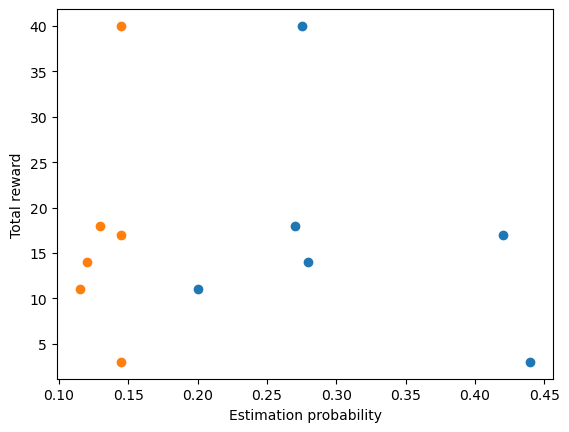

In [890]:
plt.figure()
plt.plot(est_prob, tot_reward, "o")
plt.plot(check_prob, tot_reward, "o")
plt.xlabel("Estimation probability")
plt.ylabel("Total reward")

In [112]:
set(c)

{0.0, 1.0, 2.0, 4.0}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 2.5)

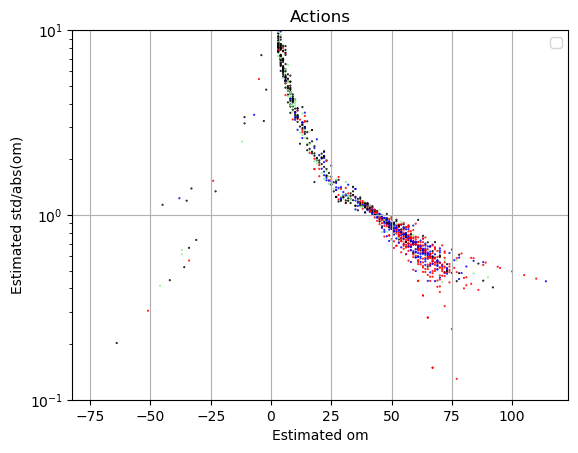

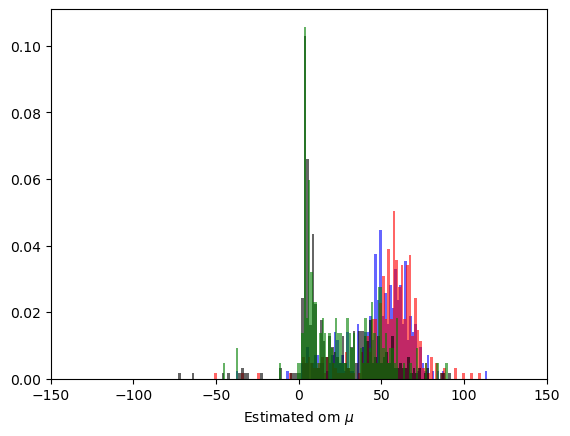

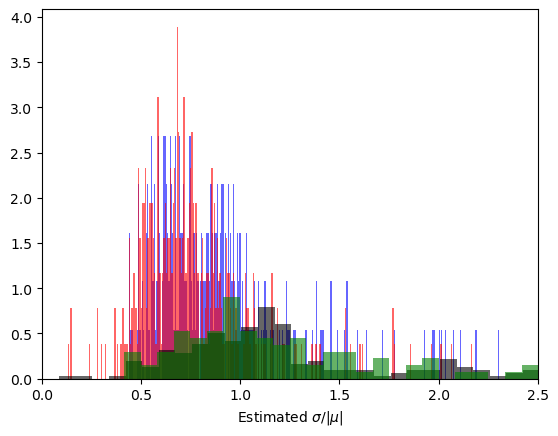

In [891]:
plt.figure()

c = actions.flatten()
y = std.flatten()
x = mus.flatten()
z = y/(np.abs(x)+0.1)


plt.title("Actions")
plt.scatter(x,z,c=c, marker=".", cmap = cmap, norm=norm, alpha=1, s=1)
plt.legend()
plt.xlabel("Estimated om")
plt.ylabel("Estimated std/abs(om)")
plt.grid()
plt.ylim(0.1,10)
plt.yscale("log")

plt.figure()
plt.hist(x[np.where(c==0)],color="b", bins = 100, alpha=0.6, density=True)
plt.hist(x[np.where(c==1)],color="r", bins = 100, alpha=0.6, density=True)
plt.hist(x[np.where(c==2)],color="k", bins = 100,alpha=0.6, density=True)
plt.hist(x[np.where(c==4)],color="g", bins = 100,alpha=0.6, density=True)
plt.xlabel("Estimated om $\mu$")
plt.xlim(-150,150)
plt.figure()
plt.hist(z[np.where(c==0)],color="b",bins = 2000,alpha=0.6, density=True)
plt.hist(z[np.where(c==1)],color="r",bins = 2000,alpha=0.6, density=True)
plt.hist(z[np.where(c==2)],color="k", bins = 2000,alpha=0.6, density=True)
plt.hist(z[np.where(c==4)],color="g", bins = 2000,alpha=0.6, density=True)
plt.xlabel("Estimated $\sigma/|\mu|$")
plt.xlim(0,2.5)

In [769]:

class cma(): 
    '''
    This is the optimization algorithm that will parametrize the Vin array using two parameters (Vmax, std).
    This would significantly limit space of parameters      
    '''
    

    def __init__(self, generations, population_size, bounds, sigma, mean, policy, episodes):
        '''
        Constructor of the cma class. It initializes the CMA-ES algorithm and sets its parameters.
        ----------
        Arguments:
            ComsolModel {ComsolModel} -- ComsolModel class object.
            generations {int} -- Number of generations to run the algorithm.
            population_size {int} -- Number of probes to evaluate per generation.
            bounds {np.array} -- Bounds of the parameters to optimize.
            sigma {float} -- Initial standard deviation of the parameters.
            mean {np.array} -- Initial guess of the parameters.
        '''
        from cmaes import CMA
        self.optimizer = CMA(mean=mean, bounds = bounds, sigma=sigma , population_size=population_size)
        self.generations = generations
        self.policy = policy
        self.epsisodes = episodes


    def optimize(self):
        ''' 
        Main optimization loop. It runs the arguments and the cost function for all evaluated points

        ----------
        Arguments:
            None
        Returns:
            solutions_all {list} -- List of all evaluated points and their cost function.
        '''
        solutions_all = []
        for gen in range(self.generations):
            solutions = []
            population = self.ask_for_batch(self.optimizer.population_size)
            f_probes = self.evaluate_batch(population)
            solutions.append(f_probes)
            solutions_all.append(solutions)
        return solutions_all
    

    def ask_for_batch(self, N):
        '''
        Function to draw the population of N samples from the current distribution
        ----------
        Arguments:
            N {int} -- Number of probes to evaluate.
        Returns:
            population {list} -- List of probes to evaluate.
        '''
        population = []
        for n in range(N):
            population.append(self.optimizer.ask())
        return population
    

    def evaluate_batch(self, population):
        '''
        Function to evaluate the cost function for the population of probes. First it extracts the features (y) and translate them into fitness (cost function).
        ----------
        Arguments:
            population {list} -- List of probes to evaluate.
        Returns:
            solutions {list} -- List of evaluated probes and their cost function.
        '''

        solutions = []
        fit = self.cost_function(y)
        solutions = [[population[k],fit[k]] for k in range(len(population))]
        self.optimizer.tell(solutions)
        return solutions
    

    def cost_function(self, y):
        '''
        WE WANT TO IMPLEMENT THIS FUNCTION 
        
        y = f(x) where x is the parameters and y is the output of comsol (features).

        Cost_function = g(y) cost function is a function of the features
        '''
        return play(self.episodes, self.policy, y)


In [970]:
from scipy import optimize
def policy_flip(mu, std, n):
    return 0

def policy_random_p(mu, std, n,x):
    pflip = x[0]/np.sum(x)
    pest = x[1]/np.sum(x)
    pcheck = x[2]/np.sum(x)

    return np.random.choice([0,1,2], p=[pflip,pest,pcheck])

def policy_random(mu, std, n):
    return np.random.choice([0,1,2], p=[1/3,1/3,1/3])

def policy_max_std(mu, std, n, x):
    std_max = x[0]
    pest = x[1]
    if std/(mu+1e-4) < std_max:
        return 0
    else:
        return np.random.choice([1,2], p=[pest,1-pest])

def policy_min_mu(mu, std, n, x):
    mu_min = x[0]
    pest = x[1]

    if mu > mu_min:
        return 0
    else:
        return np.random.choice([1,2], p=[pest,1-pest])

def policy_interval(mu, std, n, x):
    Nflip = np.floor(x[0]) 
    Nest = np.floor(x[1]) 
    Ncheck = np.floor(x[2])

    if n % (Nflip+Nest+Ncheck) < Nflip:
        return 0
    elif n % (Nflip+Nest+Ncheck) < Nflip+Nest:
        return 1
    else:
        return 2


from cmaes import CMA





policies = policy_random_p, policy_max_std, policy_min_mu, policy_interval

def optimize_policy(policy, generations, population_size, bounds, sigma, mean, episodes):
    optimizer = CMA(mean=np.array(mean), bounds = np.array(bounds), sigma=np.array(sigma) , 
                population_size=population_size)
    for gen in range(generations):
        
        population = []
        for n in range(population_size):
            population.append(optimizer.ask())
        f_probes = []
        for n in range(population_size):
            f_probes.append(-play(episodes, policy, population[n]))
        solutions = [[population[k],f_probes[k]] for k in range(len(population))]
        optimizer.tell(solutions)
        print("------")
        print(np.mean(f_probes))
        print((np.mean(population,axis=0)))

    
    return optimizer


x_tcs_opt = []
for tc in tcs:
    
    env = EstimationEnv(tc = tc)    

    def play(episodes, policy, x):
        s_total = 0
        for episode in range(1, episodes+1):
            done = False
            score = 0 
            k = 0
            n_state = env.reset()[0]
            while not done:
                action = policy(n_state[0], n_state[1], k, x)
                n_state, reward, done, _, info = env.step(action)
                mu, std = n_state
                score+=reward
                k = k+1
            s_total = s_total + score/episodes
        return s_total

    x_random_p = optimize_policy(policy_random_p, generations = 5, population_size=10, 
                            bounds = [[0,1],[0,1],[0,1]], sigma = 0.5, mean=[0.7,0.2,0.1], episodes = 10)

    '''
    x_max_std = optimize_policy(policy_max_std, generations = 5, population_size=10,
                            bounds = [[0,10],[0,1],[0,1]], sigma = 0.5, mean=[0.5,0.8,0.5], episodes = 10)


    x_min_mu = optimize_policy(policy_min_mu, generations = 5, population_size=10,
                        bounds = [[0,1000],[0,1],[0,1]], sigma = 10., mean=[20.,0.8,0.5], episodes = 10)


    x_int = optimize_policy(policy_interval, generations = 5, population_size=10,
                            bounds = [[0,50],[0,50],[0,50]], sigma = 10., mean=[20.,5.,2.], episodes = 10)

    '''
    x_tcs_opt.append([x_random_p.ask(), x_max_std.ask(), x_min_mu.ask(), x_int.ask() ])

------
-8.05
[0.56969935 0.50388455 0.31135788]
------
-8.28
[0.5569767  0.43327322 0.44202786]
------
-9.850000000000001
[0.55926293 0.44564222 0.23020935]
------
-11.23
[0.55371359 0.3756898  0.2104781 ]
------
-13.77
[0.63144723 0.29286504 0.196285  ]
------
-10.580000000000002
[0.522479   0.45835862 0.47193199]
------
-15.290000000000001
[0.8051262  0.46702775 0.52581124]
------
-15.420000000000002
[0.72979959 0.40482919 0.33347154]
------
-15.620000000000001
[0.73923065 0.48850157 0.37600327]
------
-19.2
[0.8195717  0.52626227 0.33547106]
------
-20.61
[0.71509719 0.28739617 0.40837917]
------
-19.389999999999997
[0.59499891 0.35228227 0.29938802]
------
-20.979999999999997
[0.6821453  0.41382181 0.2112331 ]
------
-19.29
[0.71953032 0.41157846 0.29054845]
------
-18.57
[0.72500222 0.43138307 0.21088175]
------
-15.65
[0.59262637 0.50485612 0.40693012]
------
-21.229999999999997
[0.69045164 0.50269947 0.39509424]
------
-19.99
[0.60865843 0.44693143 0.25365452]
------
-20.5099999

In [937]:
policies = 7
'''
-always flip
-random
-random with flip p =0.8, est p = 0.15, check p = 0,5
-flip only if std/mu below 0.5
-flip only if mu is above 10
-estimate 5 shots every 30 shots
-agent
'''





#model = model.load("ppo_bayes2")
dones = False
samples = 3
runs = 1000

check_prob = np.zeros((len(tcs),policies,samples))
est_prob = np.zeros((len(tcs),policies,samples))
tot_reward = np.zeros((len(tcs),policies,samples))

for tcn, tc in enumerate(tcs):
    model = model.load("ppo_bayes_no_bayes"+str(tc))
    actions = np.zeros((policies,samples, runs))
    rewards = np.zeros((policies,samples, runs))
    oms = np.zeros((policies,samples, runs))
    mus = np.zeros((policies,samples, runs))
    std = np.zeros((policies,samples, runs))
    env = EstimationEnv(tc = tc)
    for p in range([2,6]):
        print(p)
        for i in range(samples):
            #print(i)
            k = 0
            dones = False
            obs = env.reset()[0]
            while not dones:
                if p==0:
                    action = 0
                elif p==1:
                    action = np.random.choice([0,1,2])
                elif p==2:
                    action = policy_random_p(obs[0], obs[1], k, x_tcs_opt[tcn][0])
                elif p==3:
                    action = policy_max_std(obs[0], obs[1], k, x_tcs_opt[tcn][1])
                elif p==4:
                    action = policy_min_mu(obs[0], obs[1], k, x_tcs_opt[tcn][2])
                elif p==5:
                    action = policy_interval(obs[0], obs[1], k, x_tcs_opt[tcn][3])
                elif p==6:
                    action, _states = model.predict(obs)
                #print(action, p,i,k)
                obs, reward, dones, truncate, info = env.step(action)
                rewards[p,i,k] = reward
                actions[p,i,k] = action*2
                if actions[p,i,k] == 0:
                    actions[p,i,k] = reward 
                oms[p,i,k] = info["om"]
                mus[p,i,k] = obs[0]
                std[p,i,k] = obs[1]
                k = k+1
            #print(np.sum(rewards[p,i,:]))
            check_prob[tcn,p,i] = np.sum(actions[p,i,:]==4)/len(actions[p,i,:])
            est_prob[tcn,p,i] = np.sum(actions[p,i,:]==2)/len(actions[p,i,:])
            tot_reward[tcn, p,i] = np.sum(rewards[p,i,:])

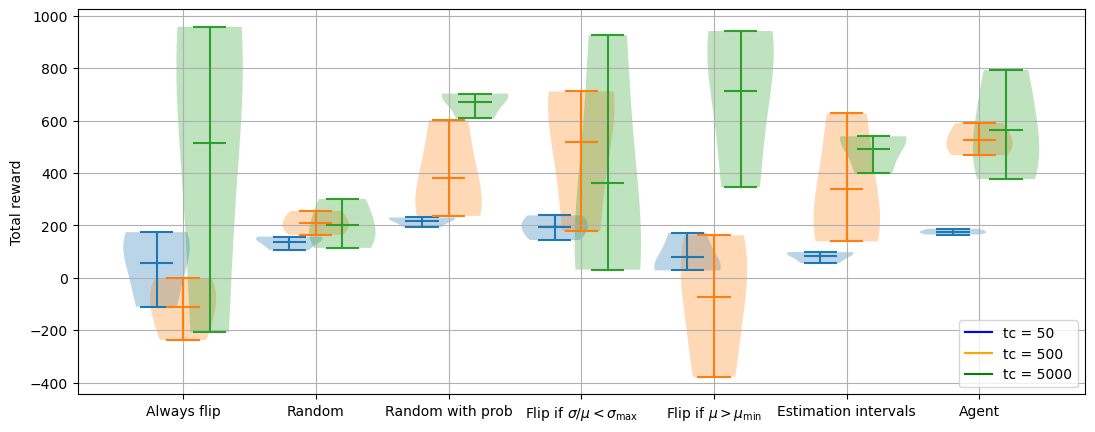

In [941]:
#compare rewards using different policies via violin plot
plt.figure(figsize=(13,5))
for tcn,tc in enumerate(tcs):
    plt.violinplot(tot_reward[tcn].T, showmeans=True, positions=np.arange(1,8)-.2+tcn*0.2, widths=0.5)
plt.xticks(np.arange(1,8),["Always flip","Random","Random with prob",r"Flip if $\sigma/\mu<\sigma_\text{max}$",r"Flip if $\mu>\mu_\text{min}$",
                            "Estimation intervals","Agent"])
plt.ylabel("Total reward")
#plt.ylim(-200,550)
plt.grid()
plt.plot([],[],color = "blue", label="tc = 50")
plt.plot([],[],color = "orange", label="tc = 500")
plt.plot([],[],color = "green", label="tc = 5000")
plt.legend(loc="lower right")


In [934]:
tot_reward[0]

array([[  0.,   0., -54.],
       [  0.,   0.,  73.],
       [  0.,   0., 232.],
       [  0.,   0., 147.],
       [  0.,   0.,  30.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

: 

2023-11-04 08:13:37.568381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
